# Import Useful Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.1


# Load and Unzip Dataset

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/GAN_datasets/anime.zip -d /

In [5]:
!ls /

bin	 datalab  home	  lib32  mnt   root  srv    tensorflow-1.15.2  usr
boot	 dev	  images  lib64  opt   run   swift  tmp		       var
content  etc	  lib	  media  proc  sbin  sys    tools


In [3]:
import glob
input_images = glob.glob('/images/*.jpg')
print (len(input_images))

63565


In [4]:
import cv2
for file in input_images[:10]:
    img = cv2.imread(file)
    print (img.shape)

(109, 109, 3)
(119, 119, 3)
(79, 79, 3)
(112, 112, 3)
(66, 66, 3)
(94, 94, 3)
(77, 77, 3)
(105, 105, 3)
(99, 99, 3)
(72, 72, 3)


# Display Few Data Samples

Images


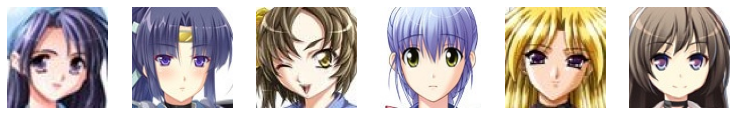

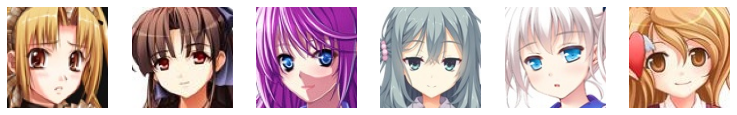

In [5]:
print ("Images")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(6):
        file = np.random.choice(input_images)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(660 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Define Generator Model (Encoder-Decoder architecture)

In [6]:
def make_generator():
    masked_image = tensorflow.keras.layers.Input(shape=(64, 64, 3))
    
    enc = masked_image
    
    #Encoder part
    enc = tensorflow.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(enc)
    
    enc = tensorflow.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(enc)
    
    enc = tensorflow.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(enc)
    
    enc = tensorflow.keras.layers.Conv2D(512, kernel_size=1, strides=2, padding='same')(enc)
    enc = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(enc)
    enc = tensorflow.keras.layers.Dropout(0.5)(enc)
    
    #Decoder part
    dec = enc
    
    dec = tensorflow.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(dec)
    dec = tensorflow.keras.layers.Activation('relu')(dec)
    dec = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(dec)
    
    dec = tensorflow.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(dec)
    dec = tensorflow.keras.layers.Activation('relu')(dec)
    dec = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(dec)
    
    dec = tensorflow.keras.layers.Conv2D(3, kernel_size=3, padding='same')(dec)
    
    missing_image = tensorflow.keras.layers.Activation('tanh')(dec)
    
    return masked_image, missing_image

masked_image, missing_image = make_generator()
generator_network = tensorflow.keras.models.Model(inputs=masked_image, outputs=missing_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256   

# Define Discriminator Network

In [7]:
def make_discriminator():
    input_image = tensorflow.keras.layers.Input(shape=(16, 16, 3))
    
    x = input_image
    
    x = tensorflow.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    
    x = tensorflow.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    
    x = tensorflow.keras.layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    
    x = tensorflow.keras.layers.Flatten()(x)
    
    real_vs_fake = tensorflow.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return input_image, real_vs_fake

input_image, real_vs_fake = make_discriminator()
discriminator_network = tensorflow.keras.models.Model(inputs=input_image, outputs=real_vs_fake)
discriminator_network.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 128)         512 

In [8]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Define  Context-Encoder

In [9]:
discriminator_network.trainable=False

g_output = generator_network(masked_image)
d_output = discriminator_network(g_output)

context_encoder = tensorflow.keras.models.Model(inputs = masked_image, outputs = [g_output, d_output])
context_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
model (Functional)           (None, 16, 16, 3)         826435    
_________________________________________________________________
model_1 (Functional)         (None, 1)                 376705    
Total params: 1,203,140
Trainable params: 825,603
Non-trainable params: 377,537
_________________________________________________________________


# Compiling Models

In [10]:
context_encoder.compile(loss=['mse', 'binary_crossentropy'], optimizer=adam_optimizer, loss_weights=[0.999, 0.001])

# Define Data Generators

In [13]:
def get_masked_images(images, mask_size=16):
    y1 = np.random.randint(0, images[0].shape[0] - mask_size, len(images))
    y2 = y1 + mask_size
    x1 = np.random.randint(0, images[0].shape[0] - mask_size, len(images))
    x2 = x1 + mask_size
    
    masked_imgs = np.empty_like(images)
    missing_parts = np.empty((len(images), mask_size, mask_size, 3))
    for i, img in enumerate(images):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
        missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
        masked_img[_y1:_y2, _x1:_x2, :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs, missing_parts, (y1, y2, x1, x2) 

def get_training_samples(batch_size):
    random_files = np.random.choice(input_images, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        images.append((img-127.5)/127.5)
    images = np.array(images)
    
    masked_imgs, missing_parts, _ = get_masked_images(images)
    return masked_imgs, missing_parts

def show_generator_results(generator_network):
    images = []
    for j in range(5):
        file = np.random.choice(input_images)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        images.append((img-127.5)/127.5)
        
    masked_imgs, missing_parts, (y1s, y2s, x1s, x2s) = get_masked_images(images)

    predicted_missing_parts = generator_network.predict_on_batch(masked_imgs)
    
    print ('Masked Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(masked_imgs):
        plt.subplot(550 + 1 + j)
        plt.imshow((img+1.0)/2.0)
        plt.axis('off')
    plt.show()

    print ('Completed by Context Encoder')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        y1, y2, x1, x2 = y1s[j], y2s[j], x1s[j], x2s[j]
        filled_image = images[j].copy()
        filled_image[y1:y2,x1:x2,:] = predicted_missing_parts[j]
        plt.subplot(550 + 1 + j)
        plt.imshow((filled_image+1.0)/2.0)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()
    
    print ('Original Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(550 + 1 + j)
        plt.imshow((img+1.0)/2.0)
        plt.axis('off')
    plt.show()

# Training Context-Encoder

In [ ]:
epochs = 500
batch_size = 64
steps = 3400

for i in range(0, epochs):
    for j in range(steps): 
        if j%200 == 0:
            show_generator_results(generator_network) 

        masked_imgs, missing_parts = get_training_samples(batch_size)

        fake = np.zeros((batch_size, 1))
        real = np.ones((batch_size, 1))
        
        fake_missing_parts = generator_network(masked_imgs)
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(missing_parts, real)
        loss_d_fake = discriminator_network.train_on_batch(fake_missing_parts, fake)
        
        loss_d = np.add(loss_d_real, loss_d_fake)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        discriminator_network.trainable=False

        # Updating Generator weights
        loss_g = context_encoder.train_on_batch(masked_imgs,[missing_parts, real])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))
            

# Results

Masked Images


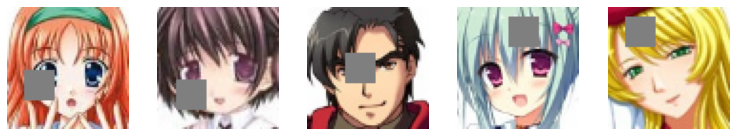

Completed by Context Encoder


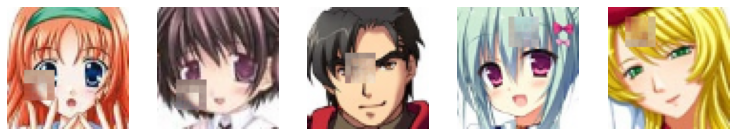

Original Images


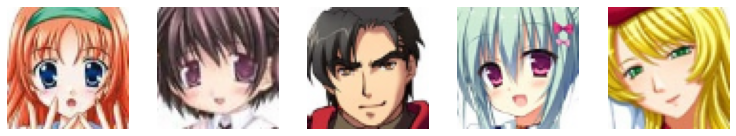

----------------------------------------------------------------------------------------------------
Masked Images


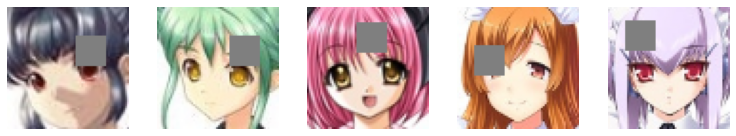

Completed by Context Encoder


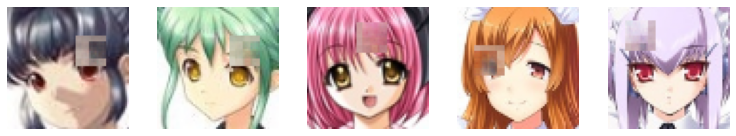

Original Images


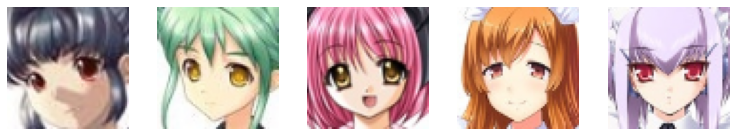

----------------------------------------------------------------------------------------------------


In [16]:
for i in range(2):
    show_generator_results(generator_network) 
    print ("-"*100)